In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression
import keras
from keras import layers, models
from keras.callbacks import EarlyStopping

In [ ]:
mask = nib.load('/content/drive/MyDrive/1 Sagol Project/Mask/Tian_Subcortex_S3_3T.nii').get_fdata()

striatum = list(range(11, 19)) + list(range(22,24)) + list(range(36, 44)) + list(range(47,49))


bool_mask = np.isin(mask, striatum)

mask[~bool_mask] = 0
mask[bool_mask] = 1

mask = mask.flatten()
mask = np.stack([mask for i in range(50)])
mask = np.transpose(mask)


In [ ]:
pet_folder_path = '/content/drive/MyDrive/1 Sagol Project/PET/'

# load PET data

original_Y = []

for file in os.listdir(pet_folder_path):
  file_path = os.path.join(pet_folder_path, file)
  temp_pet = nib.load(file_path).get_fdata()
  temp_pet = temp_pet.flatten()[mask[:,0] != 0]
  original_Y.append(temp_pet)


In [ ]:
# load fMRI data that has been standardized

X = np.loadtxt('/content/drive/MyDrive/1 Sagol Project/Linear Models/Multi Output Regression/X_Multi_Output_Striatum_Only.txt')

In [ ]:
# format fMRI data according to model 2D structure

X_reshaped = X.reshape((260, 91, 109, 50))

DMN_Motor = [2,3,4,5,7,8,21,23,24,39,40,47,49]
X_segmented = [X_reshaped[:,:,:,i] for i in DMN_Motor]

X_partition = [0 for i in range(13)]

for j in range(13):

  X_partition[j] = [0 for i in range(26)]

  for i in range(26):

    X_partition[j][i] = X_segmented[j][10*i:10*(i+1),:]

In [ ]:
# format PET data to model 2D structure

Y_list = []

for i in range(26):
  pet_copy = np.copy(original_Y[i])

  unmasked_pet = np.copy(mask[:,0])

  for k in range(len(mask[:,0])):
    if unmasked_pet[k] == 1:
      unmasked_pet[k] = pet_copy[0];
      pet_copy = pet_copy[1:];

  Y_list.append(unmasked_pet.reshape((91,109,91)));

temp_Y = np.zeros((260, 91, 109))
k = 0

for i in range(26):

  for j in range(30,40):

    temp_Y[k, :, :] = Y_list[i][:,:,j]
    k += 1

Y_list = [0 for i in range(26)]
for i in range(26):
  Y_list[i] = temp_Y[10*i:10*(i+1),:]

Y_list_reshaped = [Y_list[i].reshape((10, 91, 109)) for i in range(26)]
Y_list_temp = [np.zeros((91,109,91)) for i in range(26)]

for i in range(26):
  for k in range(91):
    if k in range(30,40):

      Y_list_temp[i][:, :, k] = Y_list_reshaped[i][k-30, :, :]

Y_list_masked = [Y_list_temp[i].flatten() for i in range(26)]
Y_list_masked = [Y_list_masked[i][mask[:,0] != 0] for i in range(26)]

X, X_val = [0 for i in range(13)], [0 for i in range(13)]
Y, Y_val = [0 for i in range(13)], [0 for i in range(13)]
for i in range(13):
  X[i], X_val[i] = X_partition[i][:20], np.concatenate(X_partition[i][20:])
  Y[i], Y_val[i] = Y_list[:20], np.concatenate(Y_list[20:])

r_matrix = np.zeros((20,20))
batch_pred = np.zeros((3078, 4))
r_arr = np.zeros((20,4))

In [ ]:
# initialize early stopping parameter for the model

callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# build base encoder for each brain network

def build_base_model():
  input = keras.layers.Input(shape=(91,109,1,))
  x = keras.layers.Conv2D(32, (3, 3), activation="relu", padding='same')(input)
  x = keras.layers.ZeroPadding2D(padding=((1,0),(1,0)))(x)
  x = keras.layers.MaxPooling2D((2, 2), padding="same")(x)
  x = keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
  x = keras.layers.ZeroPadding2D(padding=((0,0),(1,0)))(x)
  x = keras.layers.MaxPooling2D((2, 2), padding="same")(x)
  x = keras.layers.Flatten()(x)
  output = keras.layers.Dense(100, activation = 'relu')(x)
  return keras.models.Model(input, output)



In [ ]:
# 5-fold cross validation routine of meta-model assmebly, training and prediction

for i in range(5):

  inputs = [keras.layers.Input(shape=(91,109,1)) for i in range(13)]
  models = [build_base_model() for i in range(13)]
  x = [models[i](inputs[i]) for i in range(13)]
  y = keras.layers.Concatenate(axis=-1)(x)
  y = keras.layers.Dense(1344, activation = 'relu')(y)
  y = keras.layers.Reshape((6, 7, 32))(y)
  y = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(y)
  y = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(y)
  y = layers.Cropping2D(cropping=((1,0),(0,0)))(y)
  y = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(y)
  y = layers.Cropping2D(cropping=((0,0),(1,0)))(y)
  y = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(y)
  y = layers.Conv2D(1, (3, 3), activation="linear", padding="same")(y)
  output = layers.Cropping2D(cropping=((1,0),(1,0)))(y)

  nn = keras.models.Model(inputs,output)
  nn.compile(loss="mse", optimizer='adam')

  features, target, test = [0 for n in range(13)], [0 for n in range(13)], [0 for n in range(13)]

  for l in range(13):
    features[l] = np.concatenate(X[l][:16])
    target[l] = np.concatenate(Y[l][:16])
    test[l] = np.concatenate(X[l][16:])

  nn.fit(features, target, epochs = 100, batch_size = 1,
                shuffle=True, validation_data = (X_val, Y_val,),
                   verbose = 1, callbacks = [callback])
  pred = nn.predict(test)
  pred = np.split(pred, 4)

  for j in range(4):

    temp_pred = pred[j]

    temp_pred_masked = np.zeros((91,109,91))

    for k in range(91):
      if k in range(30,40):
        temp_pred_masked[:, :, k] = temp_pred[k-30, :, :,0]

    temp_pred_masked = temp_pred_masked.flatten()
    temp_pred_masked = temp_pred_masked[mask[:,0] != 0]
    batch_pred[:,j] = temp_pred_masked
    r_arr[:,j] = [r_regression(Y_list_masked[m].reshape(-1,1), batch_pred[:,j])[0] for m in range(20)]

  r_matrix[:, 16 - 4*i : 20 - 4*i] = r_arr

  for z in range(6):
    for j in range(4):
      X[z].insert(0, X[z].pop(19))
      Y[z].insert(0, Y[z].pop(19))

  print(i)



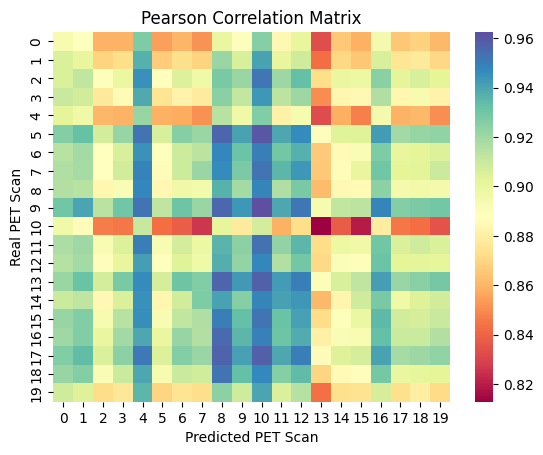

In [ ]:
# plot correlation matrix for all subject excluding validation set (20 subjects)

fig = sns.heatmap(r_matrix, cmap = 'Spectral')
fig.set_title('Pearson Correlation Matrix')
fig.set(xlabel='Predicted PET Scan', ylabel='Real PET Scan')
plt.show()

In [ ]:
# extract meaningful values from the matrix

r_diag = np.array([r_matrix[i,i] for i in range(20)])
r_diag_mean = r_diag.mean()
r_mean = r_matrix.mean()
r_std = r_matrix.std()
[r_mean, r_diag_mean, r_diag_mean - r_mean, r_std]

[0.906748087255305,
 0.9081152745036233,
 0.0013671872483183023,
 0.02920840920308092]